# serial-comm: comunicación y registro de datos por puerto serial
Autor: Claudio Morales D.<br>
https://github.com/cmoralesd/serial-comm <br>
Otoño 2023<br>
<br>
Código base para establecer comunicación por puerto serial entre un dispositivo Arduino (o similar) y un script de Python, utilizando la librería **pyserial**, controlar entradas y salidas del módulo Arduino mediante valores numéricos intercambiados en formato de texto, registrar datos en un archivo CSV, procesar los datos utilizando las herramientas básicas de la librería **pandas** y obtener gráficos de los datos registrados utilizando **matplotlib.pyplot**.

Para comprender las características generales de la comunicación serial, consulte: https://hetpro-store.com/TUTORIALES/puerto-serial/

Los archivos para programación del módulo Arduino se encuentran en https://github.com/cmoralesd/serial-comm


In [2]:
# librerías requeridas
import serial  # librería pyserial, para comunicación con los puertos serial < pip install pyserial >
import time    # para el manejo de eventos de tiempo, nativa de Python
import pandas as pd  # para el manejo de archivos de datos < pip install pandas >
import matplotlib.pyplot as plt # para realizar gráficos < pip install matplotlib >


# funciones para enviar y recibir mensajes en formato de texto, codificado en UTF-8
# los mensajes utilizan como terminador un caracter de final de línea '\n'
def encode_send(ser, texto):
    enc = f'{texto}\n'.encode('UTF-8')
    ser.write(enc)

def decode_response(ser):
    message_from_serial = ser.readline()
    res = message_from_serial[:-1].decode()
    return res


### 1. Código base en esquema request-response

El esquema de comunicación utilizado es **maestro-esclavo** (master-slave) en modo **request-response** (requerimiento-respuesta): sólo un dispositivo puede iniciar la comunicación enviando un requerimiento y el otro dispositivo responde. 

En este caso, el script de Python siempre inicia la comunicación, con un mensaje de texto que contiene dos valores enteros separados por una coma (,). El dispositivo Arduino recibe el mensaje, lo procesa, y envía una respuesta.

El código utilizado en Arduino es: **serial-comm.ino**

In [3]:
# Esquema básico para request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
val_0 = 123
val_1 = 456
message_to_serial = str(val_0) + ',' + str(val_1)

# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')
print(f'recibido: {message_from_serial}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')


enviado: 123,456
recibido: Arduino OK
el puerto se ha cerrado correctamente


### 2. Enviando mensajes en forma cíclica

El código utilizado en Arduino es: **serial-comm.ino**

In [4]:
# Esquema básico para comunicarse por puerto serial en forma cíclica
# El código utilizado en Arduino es: serial-comm.ino
serialport.close()
# inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 1. # se deja en segundos

# inicia el ciclo de intercambio de datos
while time_elapsed < time_stop:
    # Preparamos el mensaje a ser transmitido
    val_0 = 0
    val_1 = 0
    message_to_serial = str(val_0) + ',' + str(val_1)

    # enviamos al puerto y esperamos la respuesta
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    # procesamos la respuesta
    print(f'enviado: {message_to_serial}')
    print(f'recibido: {message_from_serial}')

    #aCTUALIZAR EL TIEMPO
    time_elapsed = time.perf_counter() - time_start
    print(f'tiempo: {time_elapsed}')
    time.sleep(0.2)

# cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 0,0
recibido: Arduino OK
tiempo: 0.5289576000068337
enviado: 0,0
recibido: 223;0
tiempo: 0.7598534999415278
enviado: 0,0
recibido: 287;1022
tiempo: 0.9791554999537766
enviado: 0,0
recibido: 1022;124
tiempo: 1.2111225998960435
el puerto se ha cerrado correctamente


In [5]:
time.perf_counter()

1387518.1629489

### 2. Controlando pines I/O en el dispositivo Arduino

El código utilizado en Arduino es: **serial-control.ino**

In [6]:
# Esquema básico para control de pines I/O en modo request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
led_verde = 1   # 0 = apagado, otro valor = encendido
led_rojo = 128     # nivel PWM entre 0 y 255
message_to_serial = str(led_verde) + ',' + str(led_rojo)
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)
# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')

data = message_from_serial.split(';')
val_x = int(data[0])
val_y = int(data[1])
print(f'val_x = {val_x}')
print(f'val_y = {val_y}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 1,128
val_x = 0
val_y = 0
el puerto se ha cerrado correctamente


In [7]:
serialport.close()

### 4. Registrando datos recibidos desde el puerto serial

El código utilizado en Arduino es: **serial-control.ino**

In [13]:
# Registro de transacciones vía puerto serial
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicaciones
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)
# 2. Inicializa el archivo de registro de datos
filename = 'dataset-' + time.strftime('%d-%m-%y-%H%M%S') + '.csv'
with open(filename,'w') as file:
    file.write('tiempo,led_verde,led_rojo,val_x,val_y\n')

# 3. Registra las transacciones durante un periodo de tiempo especificado
time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 5. # se deja en segundos

while time_elapsed < time_stop:
    led_verde = 1   # 0 = apagado, otro valor = encendido
    led_rojo = time_elapsed/time_stop *255     # nivel PWM entre 0 y 255
    message_to_serial = str(led_verde) + ',' + str(led_rojo)
    encode_send(serialport, message_to_serial)

    message_from_serial = decode_response(serialport)
    encode_send(serialport, message_to_serial)
    
    message_from_serial = decode_response(serialport)
    
    data = message_from_serial.split(';')
    val_x = int(data[0])
    val_y = int(data[1])
    print(f'enviado: {message_to_serial}')
    print(f'recibido: {message_from_serial}')

    with open(filename, 'a') as file:
        file.write(str(time_elapsed) + ',' + str(led_verde) + ',' +  str(led_rojo) + ',' +  str(val_x) + ',' + str(val_y) + '\n')
    
    time_elapsed = time.perf_counter() - time_start

# 4. Cierra el puerto de comunicaciones
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 1,0.0016014003194868565
recibido: 928;0
enviado: 1,29.410368900513276
recibido: 1023;567
enviado: 1,33.117441608570516
recibido: 616;1022
enviado: 1,36.90624690963887
recibido: 0;1023
enviado: 1,40.43798670661636
recibido: 0;0
enviado: 1,43.59698280924931
recibido: 901;0
enviado: 1,46.831912802299485
recibido: 1023;523
enviado: 1,50.4182583054062
recibido: 929;1023
enviado: 1,53.91016200184822
recibido: 0;1021
enviado: 1,57.40555920707993
recibido: 0;164
enviado: 1,60.65160210756585
recibido: 505;0
enviado: 1,63.8061714002397
recibido: 1023;66
enviado: 1,67.39242000854574
recibido: 1023;1023
enviado: 1,71.01843330496922
recibido: 121;1022
enviado: 1,74.61384660587646
recibido: 0;523
enviado: 1,77.95110300625674
recibido: 0;0
enviado: 1,81.0986343047116
recibido: 1022;0
enviado: 1,84.29128020233475
recibido: 1023;790
enviado: 1,87.9365307027474
recibido: 505;1022
enviado: 1,91.48493220191449
recibido: 0;658
enviado: 1,94.78306650719605
recibido: 0;0
enviado: 1,97.93033260363154

In [9]:
time.strftime('%d-%m-%y-%H%M%S')

'02-06-23-191606'

In [14]:
df = pd.read_csv(filename)
df

,tiempo,led_verde,led_rojo,val_x,val_y
0,0.000031,1,0.001601,928,0
1,0.576674,1,29.410369,1023,567
2,0.649362,1,33.117442,616,1022
3,0.723652,1,36.906247,0,1023
4,0.792902,1,40.437987,0,0
...,...,...,...,...,...
61,4.666100,1,237.971090,1023,771
62,4.740539,1,241.767489,505,0
63,4.810056,1,245.312841,0,523
64,4.872786,1,248.512076,311,1023


<function matplotlib.pyplot.show(close=None, block=None)>

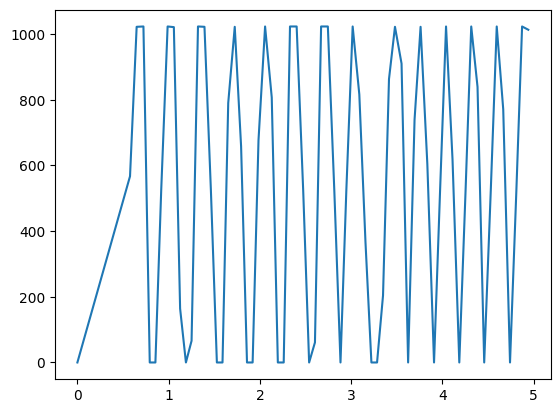

In [20]:
x=df['tiempo'].tolist()
y=df['val_y'].tolist()
ax=plt.figure().add_subplot()
ax.plot(x,y)

plt.show